In [1]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/imagenes/220119sel/220119c1/'
nombre_foto = 'ctrol1b0'
x_calibracion = 1
ancho_corte = 5

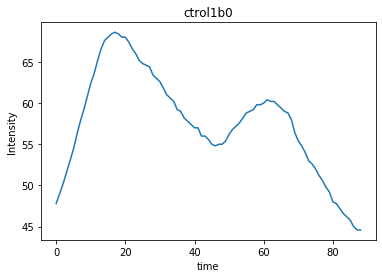

In [5]:
from PIL import Image             # funciones para cargar y manipular imágenes
import numpy as np                # funciones numéricas (arrays, matrices, etc.)
import matplotlib.pyplot as plt   # funciones para representación gráfica
%matplotlib inline
import cv2
from matplotlib.pyplot import subplots
import pandas as pd
import  csv


if __name__ == '__main__' :
# Read image
    imag = cv2.imread(path + nombre_foto + ".tif")

    if imag is None:
        print("Check file path")
    else:
        cv2.imshow ('image', imag)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Select ROI
    fromCenter = False
    showCrosshair = False
    r = cv2.selectROI(imag, fromCenter, showCrosshair)

    # Crop image
    imCrop = imag[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    up = int(r[1])
    down = int(r[1]+r[3])
    left = int(r[0])
    right = int(r[0]+r[2])

# Display cropped image
cv2.imshow("Image", imCrop)
cv2.waitKey(0)
cv2.destroyAllWindows()


################################
### PREPARACIÓN DE LA IMAGEN ###
################################

I = Image.open(path + nombre_foto + ".tif")
a=np.asarray(I,dtype=np.float32)  # convierte el objeto I en una matriz de tipo float32
Image.fromarray(a.astype(np.uint8)).save("prueba.jpg")  # primero convierte "a" a uint8, y luego a un objeto "imagen"


######################################################################################################
###HACE CORTES DE LA IMAGEN CADA INTERVALOS DE PIXELES Y LUEGO HACE UN HISTOGRAMA DE CADA INTERVALO###
######################################################################################################

## Genera una imagen en escala de grises con la que se trabaja

#             plt.figure()
#             plt.subplot(121)
#             plt.imshow(a,cmap='gray',interpolation='nearest')
#             plt.title('Imagen') 
a = cv2.bilateralFilter(a,20,300,300)

## Corta en porciones la imagen haciendo un histograma de cada una
x_data = np.asarray(range(up,down),dtype=np.float64)
list_img_row = []

whole_cell_SI = Image.fromarray(a[up:down, left:right].astype(np.uint8))
whole_cell_data = np.sum(whole_cell_SI,axis=1).tolist()
for i in range (left, right, ancho_corte):
    #recorte de la imagen en los límites del objeto
    seleccion=a[up:down,i:i + ancho_corte]
    #análisis de cada franja
    SI = Image.fromarray(seleccion.astype(np.uint8))
    img_row_sum = np.mean(SI,axis=1).tolist() #lista de datos del histograma
    list_img_row.append (img_row_sum)

#gráfico de histograma
plt.plot(img_row_sum)
plt.title(nombre_foto)
plt.xlabel("time")
plt.ylabel("Intensity")
plt.savefig('img_row_sum')
plt.show()

In [3]:
def waterfall_plot(fig,ax,X,Y,Z):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)        
        lc = LineCollection(segments, cmap='hot', norm=norm)
        # Set the values used for colormapping
        lc.set_array((Z[j,1:]+Z[j,:-1])/2)
        lc.set_linewidth(3) # set linewidth a little larger to see properly the colormap variation
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    fig.colorbar(lc) # add colorbar, as the normalization is the same for all, it doesent matter which of the lc objects we use

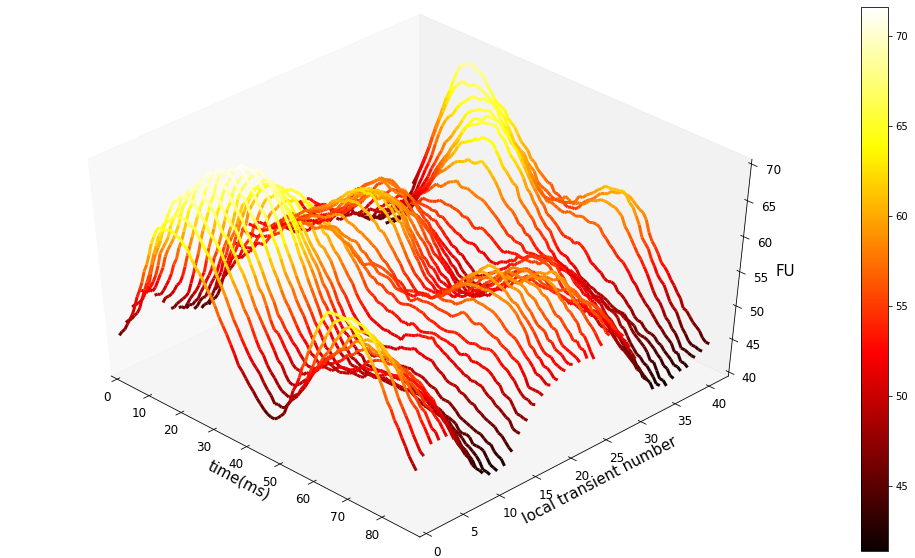

In [25]:
import numpy as np; import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y = np.array([list(range(len(img_row_sum))), list(range(len(list_img_row)))])
X,Y = np.meshgrid(x,y)
Z = np.array(list_img_row)

# Hide grid lines
ax.grid(False)
# make the panes transparent
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
waterfall_plot(fig,ax,X,Y,Z)
ax.set_xlabel('time(ms)', fontsize=15) ; ax.set_xlim3d(0,len(img_row_sum))
ax.set_ylabel('local transient number', fontsize=15) ; ax.set_ylim3d(0,len(list_img_row))
ax.set_zlabel('FU', fontsize=15) ; ax.set_zlim3d(40,70)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.view_init(45, 315)
fig.set_size_inches(18, 10, forward=True)
plt.savefig(path + 'figure3.jpg',dpi = 300)